# Simple Logistic Regression Model

This draws heavily from: http://sabermetricinsights.blogspot.com/2014/05/bayesian-linear-regression-with-pymc.html.

## Setup

In [1]:
# Libraries.

import matplotlib, matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
import pymc

In [2]:
# Settings.

% matplotlib inline

In [ ]:
# Constants.



## Data

In [3]:
# Read games.
games = pd.read_csv('../../../data/games.csv')
# Trim to single group.
games = games[games.game_group == 1]

# Store single year.
games_2014 = games[games.year == 2014]

In [5]:
games_2014.head()

,game_id,game_group,year,date,team,opponent,conference,conference_tournament,ncaa_tournament,other_tournament,...,ratio_RankAdjOE,ratio_DE,ratio_RankDE,ratio_AdjDE,ratio_RankAdjDE,ratio_Pythag,ratio_RankPythag,points_for,points_against,win
43277,20131108-airforce-army,1,2014,2013-11-08,Air Force,Army,0,0,0,0,...,1.611429,0.995965,0.959350,0.958617,0.682143,0.863300,1.105042,79,68,1
43279,20131108-akron-coastalcarolina,1,2014,2013-11-08,Coastal Carolina,Akron,0,0,0,0,...,1.626437,0.992823,0.804348,0.994553,0.918699,0.705015,1.510638,63,72,0
43281,20131108-alabama-oklahoma,1,2014,2013-11-08,Alabama,Oklahoma,0,0,0,0,...,8.250000,0.992020,0.852941,0.994295,0.835165,0.792496,2.787879,73,82,0
43282,20131108-alabamast-illinois,1,2014,2013-11-08,Illinois,Alabama St.,0,0,0,0,...,0.591973,0.956948,0.398305,0.852152,0.042146,3.916374,0.163880,80,63,1
43285,20131108-albany-siena,1,2014,2013-11-08,Albany,Siena,0,0,0,0,...,0.908333,0.979566,0.718182,1.029238,1.653846,0.908098,1.145695,74,62,1


In [44]:
# Define our data.
# x = np.array(games_2014.team_Pythag)
y = np.array(games_2014.win)

# Define our priors on intercept and error. PyMC uses precision (inverse variance).
b0 = pymc.Normal('b0', 0, 0.0003)
err = pymc.Bernoulli('err', .5)

# Features list.
features = ['diff_Tempo','diff_Pythag']

# Containers for coefficients and data.
b = np.empty(len(features), dtype=object)
x = np.empty(len(features), dtype=object)

# Traverse features.
for i, f in enumerate(features):
    b[i] = pymc.Normal('b' + str(i + 1), 0, 0.0003, value=0)
    x[i] = pymc.Normal('x' + str(i + 1), 0, 1, value=np.array(games_2014[f]), observed=True)

# Logistic function.
@pymc.deterministic
def logistic(b0=b0, b=b, x=x):
    return 1.0 / (1. + np.exp(-(b0 + b.dot(x))))

# "Model" outcome.
y_pymc = pymc.Bernoulli('win', logistic, value=y, observed=True)

# Model.
model = pymc.Model([logistic, pymc.Container(b), err, pymc.Container(x), y_pymc])

In [45]:
# Prepare for MCMC.
mcmc = pymc.MCMC(model)

# Use Metropolis.
mcmc.use_step_method(pymc.Metropolis, stochastic=b0, proposal_sd=1., proposal_distribution='Normal')
mcmc.use_step_method(pymc.Metropolis, stochastic=err, proposal_sd=1., proposal_distribution='Normal')
for bx in b:
    mcmc.use_step_method(pymc.Metropolis, stochastic=bx, proposal_sd=1., proposal_distribution='Normal')

# Sample!
mcmc.sample(10000, 2000)

 [-----------------100%-----------------] 10000 of 10000 complete in 9.8 sec

In [43]:
print mcmc.trace('b0')[:].mean()
print mcmc.trace('b1')[:].mean()
print mcmc.trace('b2')[:].mean()

0.0312121362096
0.00597928608581
6.56013813637


(array([  213.,   180.,   738.,  1964.,  1731.,  1514.,  1212.,   264.,
           88.,    96.]),
 array([-0.06714108, -0.04752738, -0.02791369, -0.00829999,  0.01131371,
         0.03092741,  0.0505411 ,  0.0701548 ,  0.0897685 ,  0.1093822 ,
         0.12899589]),
 <a list of 10 Patch objects>)

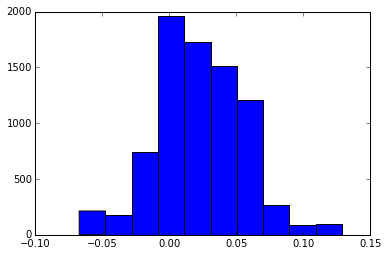

In [21]:
plt.hist(mcmc.trace('b0')[:])

(array([  6.20000000e+01,   5.63000000e+02,   1.05400000e+03,
          2.12300000e+03,   2.52900000e+03,   1.07700000e+03,
          4.56000000e+02,   1.29000000e+02,   6.00000000e+00,
          1.00000000e+00]),
 array([-0.02161987, -0.01494594, -0.00827201, -0.00159809,  0.00507584,
         0.01174977,  0.0184237 ,  0.02509762,  0.03177155,  0.03844548,
         0.04511941]),
 <a list of 10 Patch objects>)

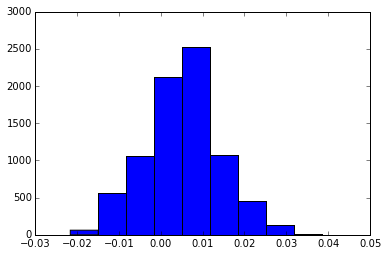

In [22]:
plt.hist(mcmc.trace('b1')[:])

(array([   20.,   166.,   504.,  1257.,  1652.,  2041.,  1370.,   654.,
          280.,    56.]),
 array([ 5.95603075,  6.07458922,  6.1931477 ,  6.31170617,  6.43026464,
         6.54882312,  6.66738159,  6.78594006,  6.90449854,  7.02305701,
         7.14161548]),
 <a list of 10 Patch objects>)

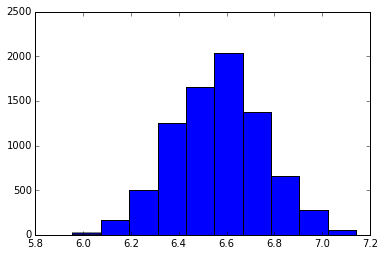

In [23]:
plt.hist(mcmc.trace('b2')[:])

(array([ 3988.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4012.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

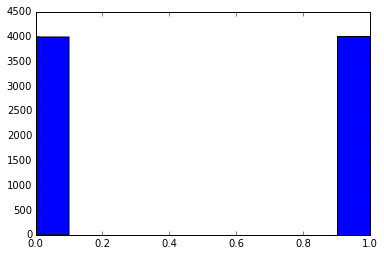

In [35]:
plt.hist(mcmc.trace('err')[:])